In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

### Load data 

In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
GS_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/gwas_max_abs_z.top500.gs'

In [3]:
DS_LIST = ['facs', 'droplet', 'aizarani', 'halpern']
DS_LIST = ['facs', 'droplet', 'aizarani']
DIC_INFO = {}
DIC_INFO['facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}
DIC_INFO['droplet'] = {'species': 'mmusculus', 'dname': 'TMS Droplet'}
DIC_INFO['aizarani'] = {'species': 'hsapiens', 'dname': 'Human liver'}
# DIC_INFO['halpern'] = {'species': 'mmusculus', 'dname': 'Mouse liver'}

In [4]:
dic_data_raw = {}
dic_data_processed = {}

# TMS FACs 
dic_data_raw['facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')
dic_data_processed['facs'] = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='Liver')['Liver']

# TMS droplet 
dic_data_raw['droplet'] = dl.load_tms_ct(DATA_PATH, data_name='droplet')
dic_data_processed['droplet'] = dl.load_tms_processed(DATA_PATH, data_name='droplet', tissue='Liver')['Liver']

# Aizarani et al. Liver atlas
dic_data_raw['aizarani'] = dl.load_aizarani_raw_data(opt='raw')
dic_data_processed['aizarani'] = dl.load_aizarani_raw_data(opt='processed')

# # Halpern et al. mouse hepatocytes
# dic_data_raw['halpern'] = dl.load_halpern_shenhav_raw_data(opt='raw')
# dic_data_processed['halpern'] = dl.load_halpern_shenhav_raw_data(opt='processed')

DNAME_LIST = list(dic_data_raw.keys())

Trying to set attribute `.obs` of view, copying.


# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


# load_tms_processed: load droplet data, tissue=[Bladder, Fat, Heart_and_Aorta, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, Mammary_Gland, Marrow, Pancreas, Skin, Spleen, Thymus, Tongue, Trachea]


/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


### Load score 

In [67]:
DIC_SCORE_PATH = {'facs': DATA_PATH+'/score_file/score.tms_facs.gwas_max_abs_z.top100',
                  'droplet': DATA_PATH+'/score_file/score.tms_droplet.gwas_max_abs_z.top500.weight_1en2',
                  'aizarani': DATA_PATH+'/score_file/score.human_liver_atlas.gwas_max_abs_z.top500'}

dic_score = {x:pd.DataFrame() for x in DNAME_LIST}
dic_trait_list = {x:[] for x in DNAME_LIST}

for ds in DNAME_LIST:
    print('# Loading scores for %s'%ds)
    for file in [x for x in os.listdir(DIC_SCORE_PATH[ds]) if '.score.gz' in x]:
        trait = file.replace('.score.gz','')
        dic_trait_list[ds].append(trait)
        temp_df = pd.read_csv(join(DIC_SCORE_PATH[ds],file), sep='\t', index_col=0)
        temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
        temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
        dic_score[ds] = pd.concat([dic_score[ds], temp_df], axis=1)

# Loading scores for facs
# Loading scores for droplet
# Loading scores for aizarani


In [68]:
# Align cells 
cell_list = list(set(dic_score['aizarani'].index) & set(dic_data_raw['aizarani'].obs_names))
dic_score['aizarani'] = dic_score['aizarani'].loc[cell_list].copy()
dic_data_raw['aizarani'] = dic_data_raw['aizarani'][cell_list, :].copy()
dic_data_processed['aizarani'] = dic_data_processed['aizarani'][cell_list, :].copy()

# cell_list = list(set(dic_score['halpern'].index) & set(dic_data_raw['halpern'].obs_names))
# dic_score['halpern'] = dic_score['halpern'].loc[cell_list].copy()
# dic_data_raw['halpern'] = dic_data_raw['halpern'][cell_list, :].copy()
# dic_data_processed['halpern'] = dic_data_processed['halpern'][cell_list, :].copy()

# Align traits 
trait_list = list(set(dic_trait_list['facs']) & 
                  set(dic_trait_list['droplet']) &
                  set(dic_trait_list['aizarani']))

# Cell list to analyze
dic_cell_list={'facs': dic_data_raw['facs'].obs_names[dic_data_raw['facs'].obs['tissue_celltype']=='Liver.hepatocyte'],
               'droplet': dic_data_raw['droplet'].obs_names[dic_data_raw['droplet'].obs['tissue_celltype']=='Liver.hepatocyte'],
               'aizarani': dic_data_raw['aizarani'].obs_names[dic_data_raw['aizarani'].obs['celltype']=='hepatocytes']}

### Analysis: association pattern

In [10]:
dic_trait_assoc_list = {x:[] for x in DNAME_LIST}

for ds in DNAME_LIST:
    print('# %s'%DIC_INFO[ds]['dname'])
    for trait in trait_list:
        v_fdr = dic_score[ds].loc[dic_cell_list[ds], '%s.fdr'%trait].values
        if (v_fdr<0.1).mean()>0.1:
            print('# ', trait, (v_fdr<0.1).sum())
            dic_trait_assoc_list[ds].append(trait)

# TMS FACS
#  UKB_460K.biochemistry_VitaminD 766
#  UKB_460K.biochemistry_Cholesterol 619
#  UKB_460K.biochemistry_LDLdirect 604
#  UKB_460K.biochemistry_ApolipoproteinB 708
#  UKB_460K.biochemistry_Triglycerides 912
#  PASS_HDL 132
#  UKB_460K.biochemistry_HDLcholesterol 599
#  UKB_460K.biochemistry_ApolipoproteinA 951
#  PASS_LDL 268
# TMS Droplet
#  UKB_460K.biochemistry_VitaminD 2663
#  UKB_460K.biochemistry_Cholesterol 2516
#  UKB_460K.biochemistry_LDLdirect 2594
#  UKB_460K.biochemistry_ApolipoproteinB 2732
#  UKB_460K.biochemistry_LipoproteinA 2290
#  UKB_460K.biochemistry_AlkalinePhosphatase 2154
#  UKB_460K.biochemistry_Triglycerides 2869
#  UKB_460K.biochemistry_AlanineAminotransferase 991
#  UKB_460K.biochemistry_ApolipoproteinA 2729
#  PASS_LDL 985
# Human liver
#  UKB_460K.biochemistry_VitaminD 1269
#  UKB_460K.biochemistry_Cholesterol 782
#  UKB_460K.biochemistry_LDLdirect 978
#  UKB_460K.biochemistry_ApolipoproteinB 792
#  UKB_460K.biochemistry_AlkalinePhosphatase 1257
#

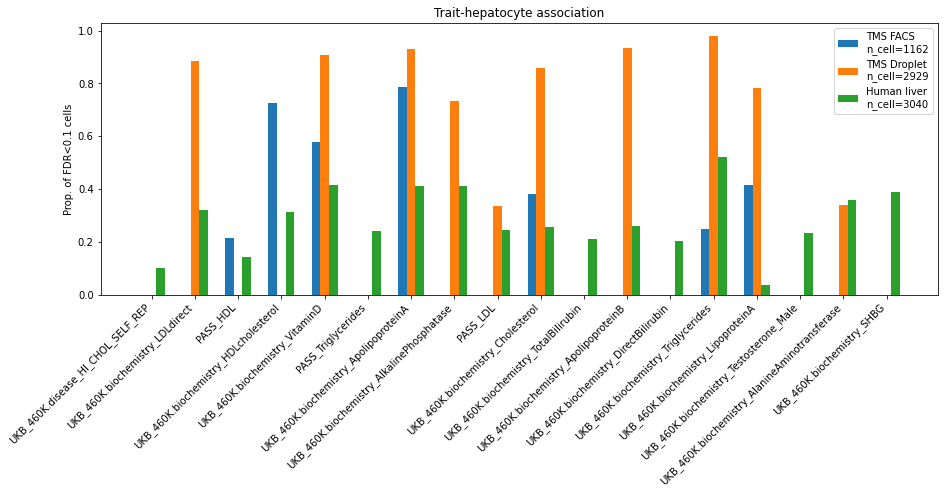

In [70]:
# Overall association pattern
trait_list_plot = list(set(dic_trait_assoc_list['facs']) | 
                       set(dic_trait_assoc_list['droplet']) | 
                       set(dic_trait_assoc_list['aizarani']))
df_plot = pd.DataFrame(index=trait_list_plot, columns=['facs', 'droplet', 'aizarani'])
dic_n_cell = {}
for trait in trait_list_plot:
    
    cell_list = dic_data_raw['facs'].obs_names[dic_data_raw['facs'].obs['tissue_celltype']=='Liver.hepatocyte']
    dic_n_cell['facs'] = len(cell_list)
    df_plot.loc[trait, 'facs'] = (dic_score['facs'].loc[cell_list, '%s.fdr'%trait]<0.1).mean()
    
    cell_list = dic_data_raw['droplet'].obs_names[dic_data_raw['droplet'].obs['tissue_celltype']=='Liver.hepatocyte']
    dic_n_cell['droplet'] = len(cell_list)
    df_plot.loc[trait, 'droplet'] = (dic_score['droplet'].loc[cell_list, '%s.fdr'%trait]<0.1).mean()
    
    cell_list = dic_data_raw['aizarani'].obs_names[dic_data_raw['aizarani'].obs['celltype']=='hepatocytes']
    dic_n_cell['aizarani'] = len(cell_list)
    df_plot.loc[trait, 'aizarani'] = (dic_score['aizarani'].loc[cell_list, '%s.fdr'%trait]<0.1).mean()
df_plot['loc'] = range(df_plot.shape[0])

plt.figure(figsize=[15,5])
plt.bar(df_plot['loc']-0.2, df_plot['facs'], width=0.2, label='TMS FACS\nn_cell=%d'%dic_n_cell['facs'])
plt.bar(df_plot['loc'], df_plot['droplet'], width=0.2, label='TMS Droplet\nn_cell=%d'%dic_n_cell['droplet'])
plt.bar(df_plot['loc']+0.2, df_plot['aizarani'], width=0.2, label='Human liver\nn_cell=%d'%dic_n_cell['aizarani'])
plt.xticks(df_plot['loc'], df_plot.index, ha='right', rotation=45)
plt.ylabel('Prop. of FDR<0.1 cells')
plt.legend()
plt.title('Trait-hepatocyte association')
plt.show()

### Heterogeneity pattern 

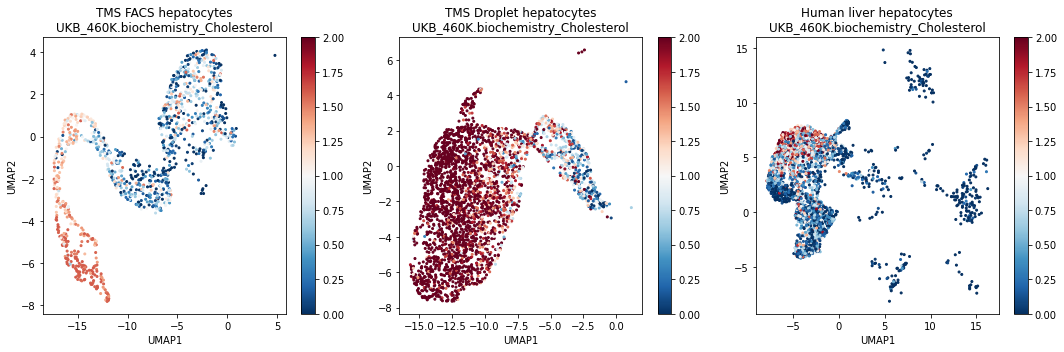

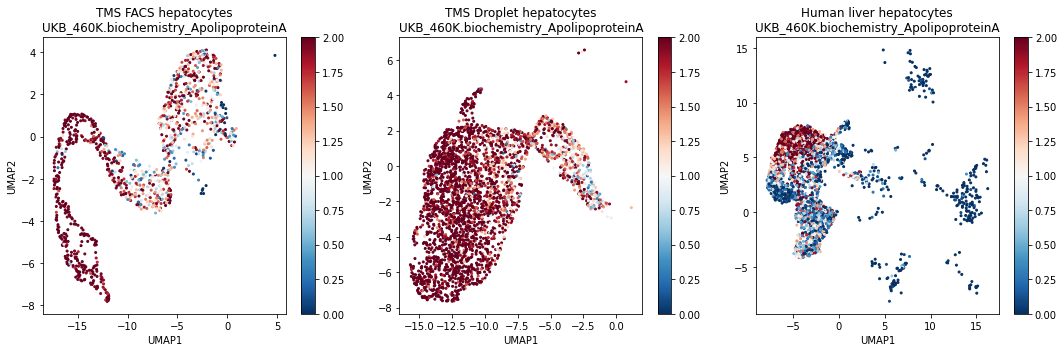

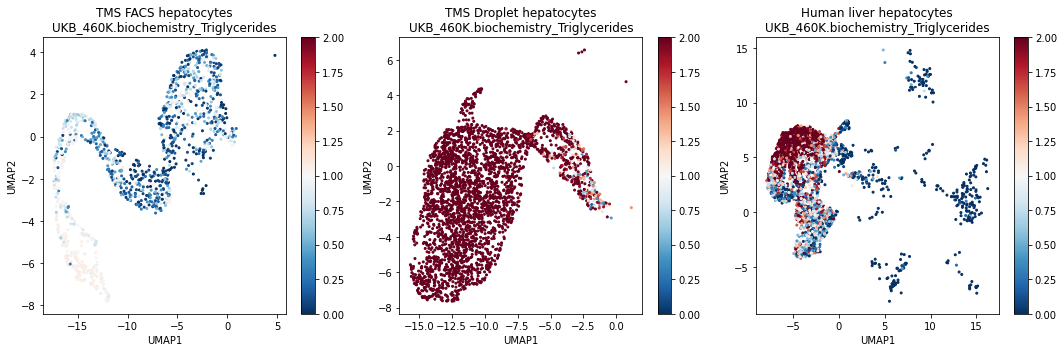

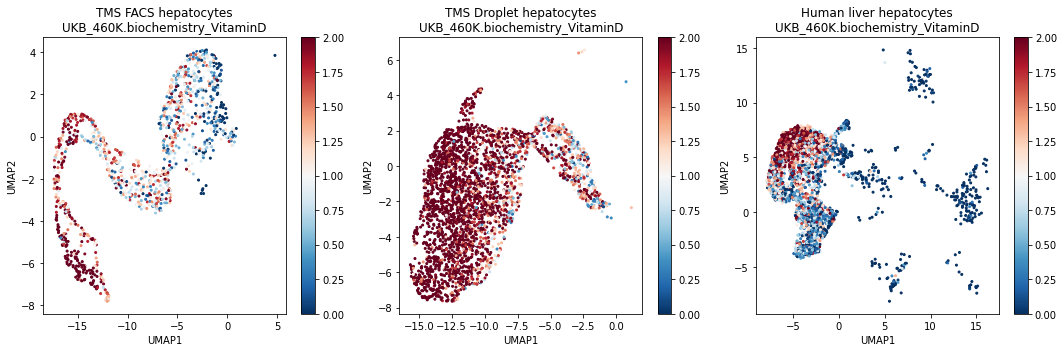

In [71]:
trait_list_plot = list(set(dic_trait_assoc_list['facs']) & 
                       set(dic_trait_assoc_list['droplet']) & 
                       set(dic_trait_assoc_list['aizarani']))

for trait in trait_list_plot:
    plt.figure(figsize=[15,5])
    for i_ds,ds in enumerate(['facs', 'droplet', 'aizarani']):
        
        df_plot = pd.DataFrame(index=dic_data_processed[ds].obs_names,
                               data={'UMAP1':dic_data_processed[ds].obsm['X_umap'][:,0],
                                     'UMAP2':dic_data_processed[ds].obsm['X_umap'][:,1]})
        df_plot = df_plot.loc[dic_cell_list[ds]]
        df_plot = df_plot.join(dic_score[ds]['%s.fdr'%trait])
        df_plot['%s.nlog10_fdr'%trait] = -np.log10(df_plot['%s.fdr'%trait])
        
        plt.subplot(1,3,i_ds+1)
        plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot['%s.nlog10_fdr'%trait],
                    cmap='RdBu_r', vmax=2, vmin=0, s=4)
        plt.colorbar()
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.title('%s hepatocytes\n%s'%(DIC_INFO[ds]['dname'], trait))
    
    plt.tight_layout()
    plt.show()

### Score-correlated genes 

In [ ]:
for i_ds,ds in enumerate(['facs', 'droplet', 'aizarani']):
    adata_small = dic_data_raw[ds][dic_cell_list[ds],:].copy()

### Covariates 

In [49]:
for ds in ['facs', 'droplet', 'aizarani']:
    if 'age' in dic_data_raw[ds].obs.columns:
        dic_data_raw[ds].obs['age_num'] = [int(x.replace('m','')) for x in dic_data_raw[ds].obs['age']]
    dic_data_raw[ds].obs['n_log_count'] = dic_data_raw[ds].X.sum(axis=1)
    dic_data_raw[ds].obs['n_gene'] = (dic_data_raw[ds].X>0).sum(axis=1)

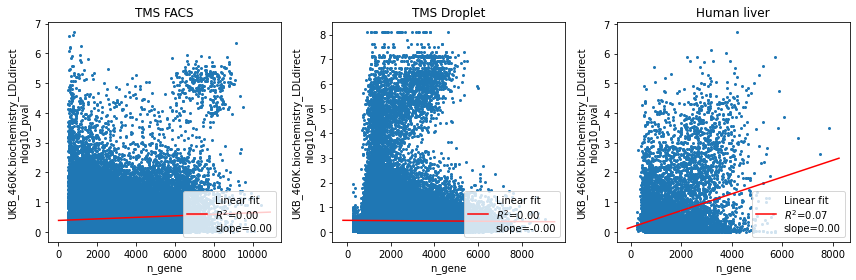

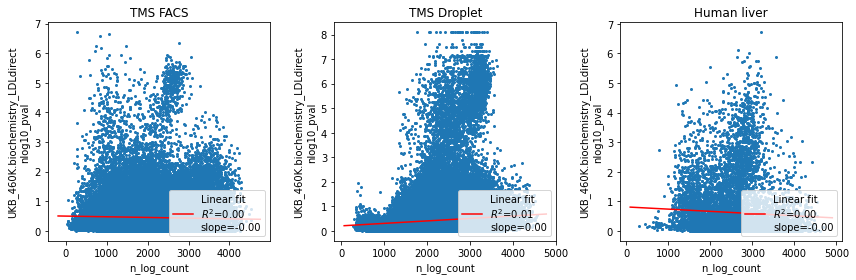

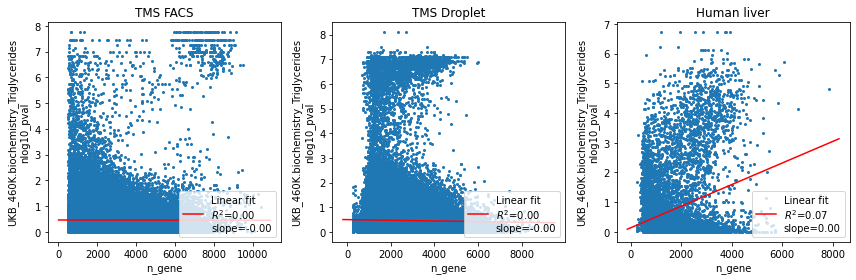

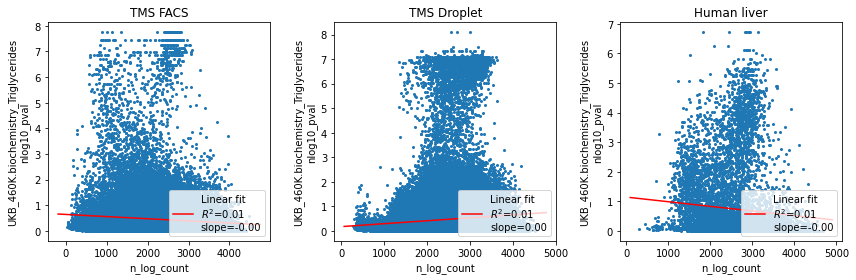

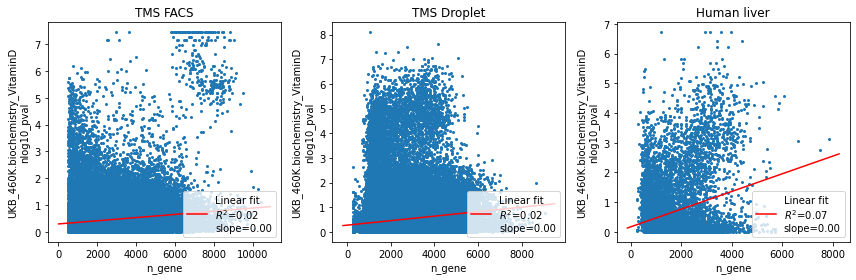

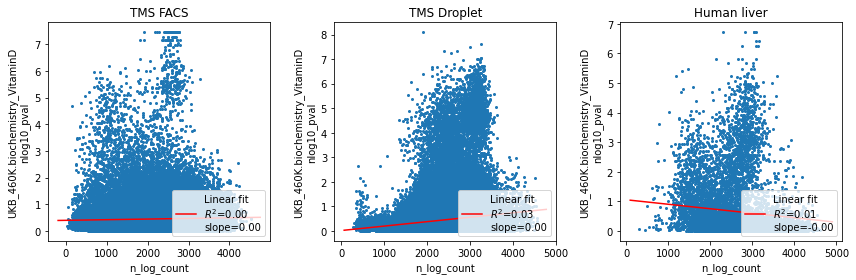

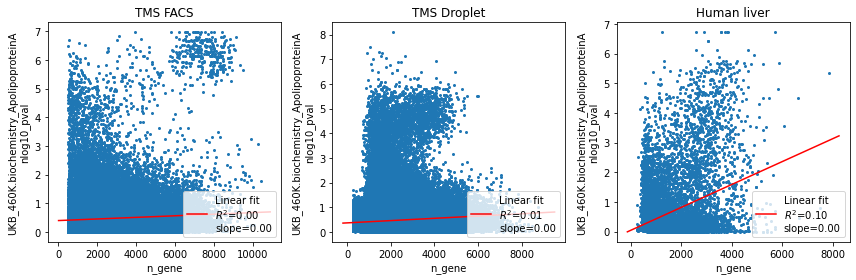

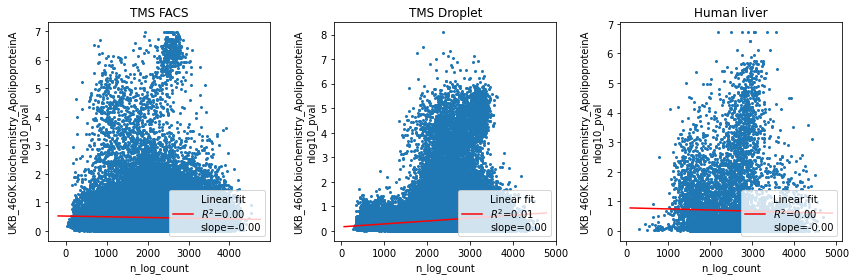

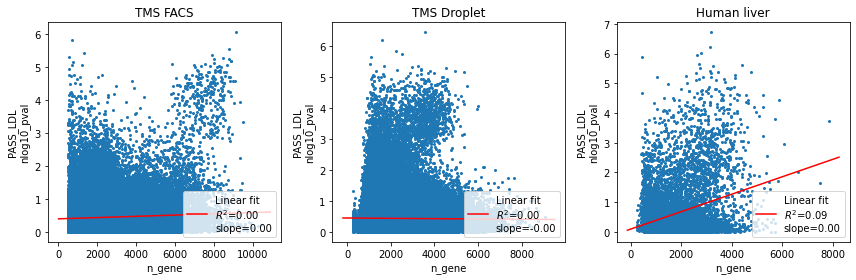

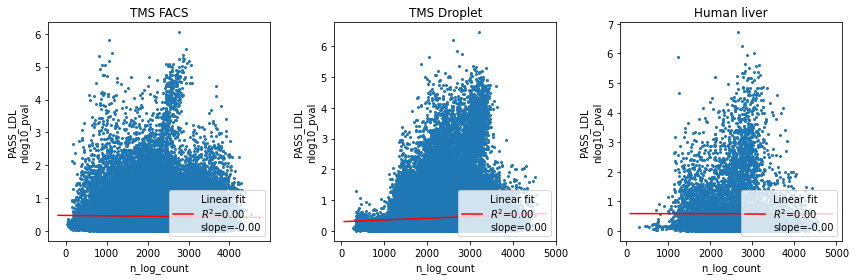

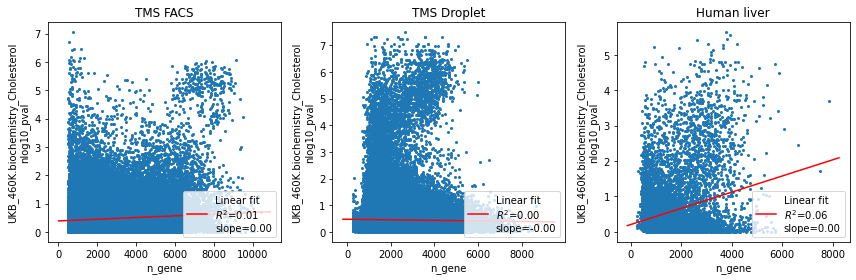

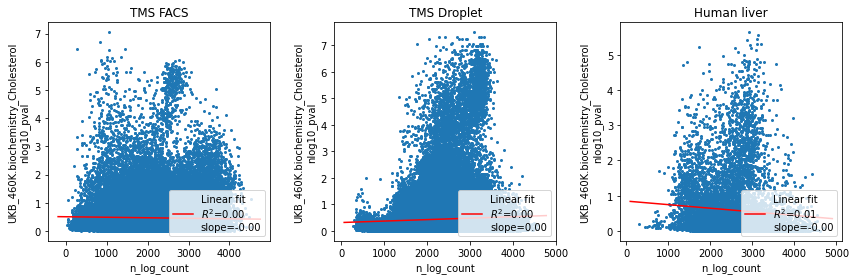

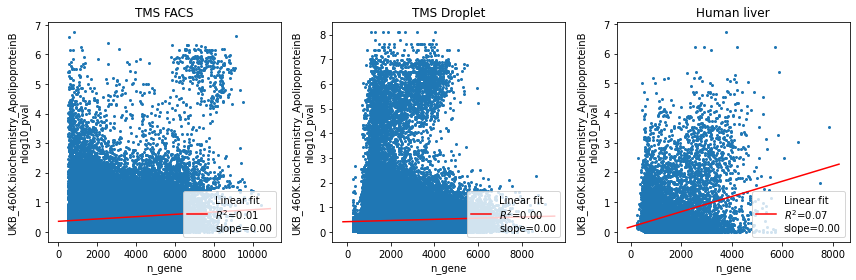

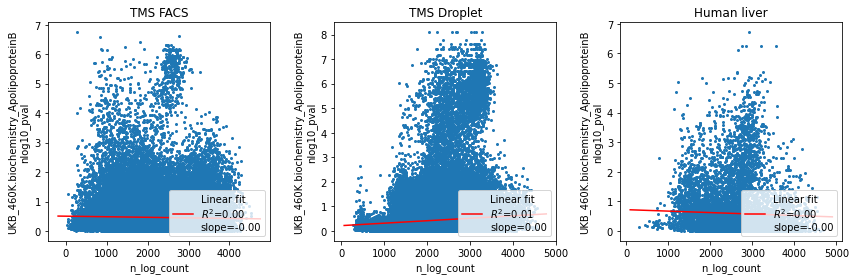

In [51]:
# Overall association
trait_list_plot = list(set(dic_trait_assoc_list['facs']) & 
                       set(dic_trait_assoc_list['droplet']) & 
                       set(dic_trait_assoc_list['aizarani']))
cov_list = ['n_gene', 'n_log_count']

for trait in trait_list_plot:
    for cov in cov_list:
        plt.figure(figsize=[12,4])
        for i_ds,ds in enumerate(['facs', 'droplet', 'aizarani']):
            
            if cov not in dic_data_raw[ds].obs.columns:
                continue
            
            cell_list = list(set(dic_score[ds].index) & set(dic_data_raw[ds].obs.index))
            v_x = dic_data_raw[ds].obs.loc[cell_list, cov].values
            v_y = -np.log10(dic_score[ds].loc[cell_list, '%s.pval'%trait])

            plt.subplot(1,3,i_ds+1)
            plt.scatter(v_x, v_y, s=4)

            # linear fit
            sl, icpt, r_val, p_val, _ = sp.stats.linregress(v_x[v_x>0], v_y[v_x>0])
            x_min,x_max = plt.xlim()
            y_min,y_max = plt.ylim()
            plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
                     label='Linear fit\n$R^2$=%0.2f\nslope=%0.1e'%(r_val**2, sl))
            plt.legend(loc='lower right')

            plt.xlabel(cov)
            plt.ylabel('%s\nnlog10_pval'%trait)
            plt.title(DIC_INFO[ds]['dname'])

        plt.tight_layout()
        plt.show()

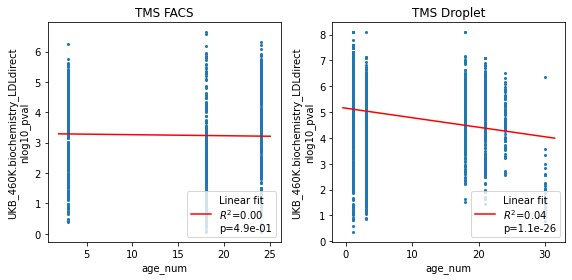

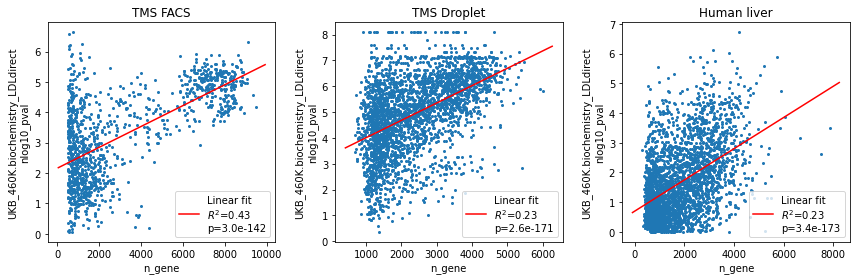

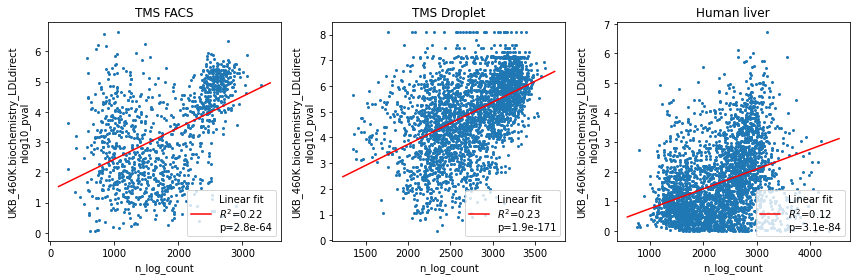

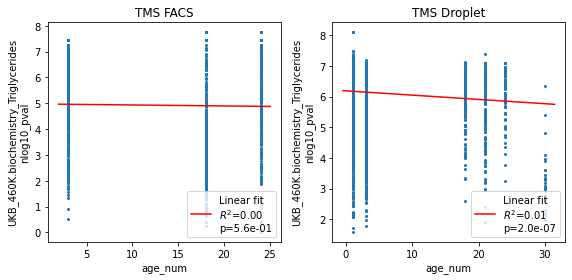

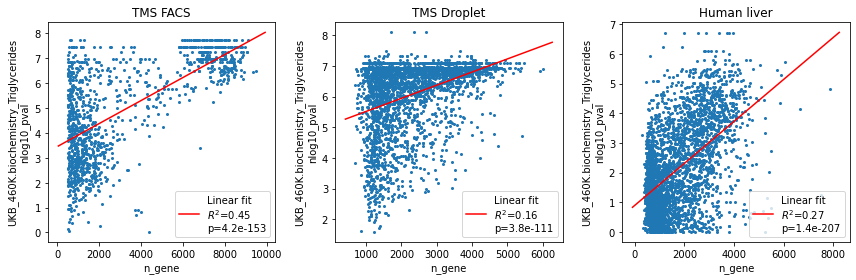

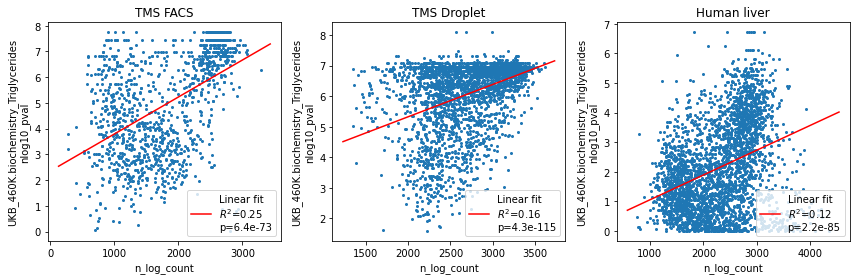

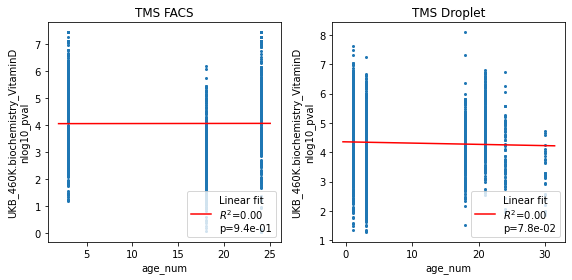

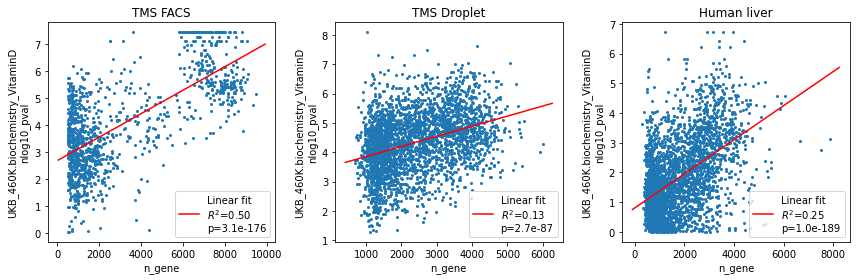

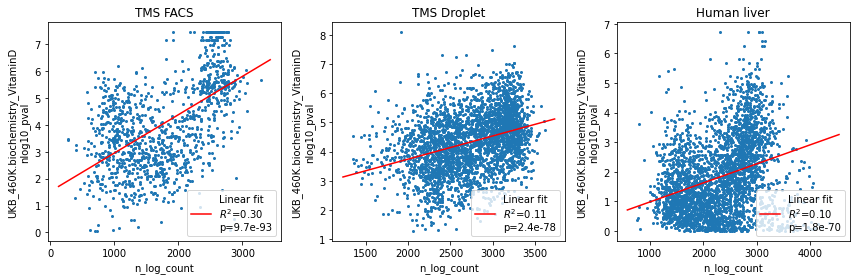

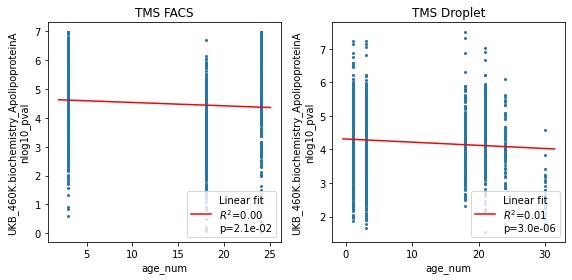

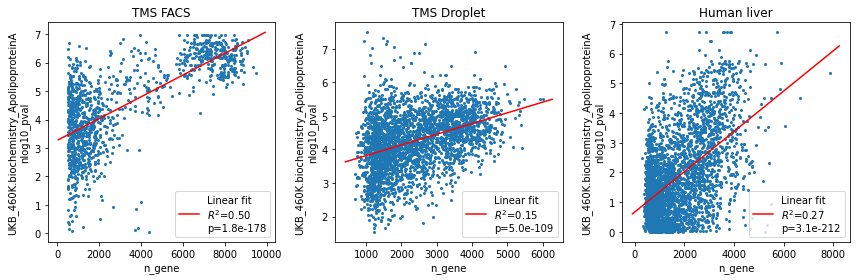

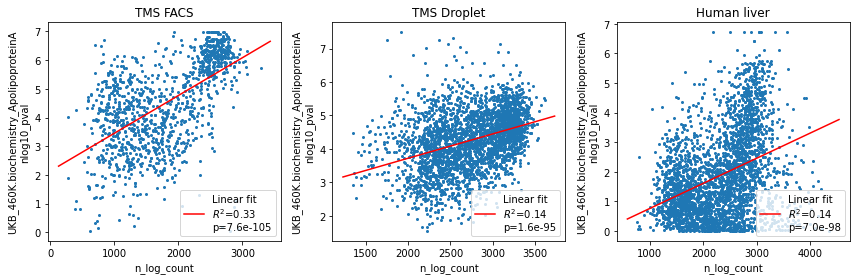

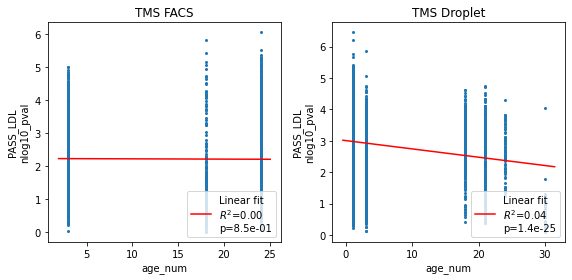

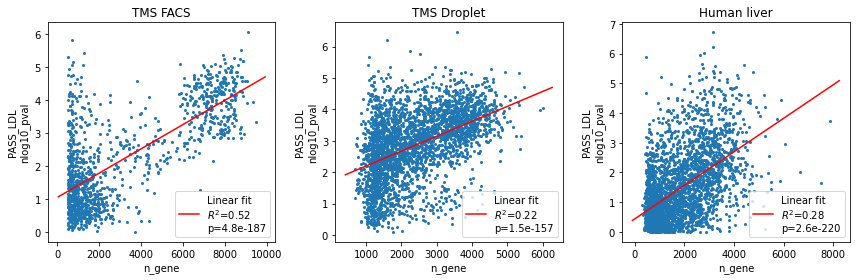

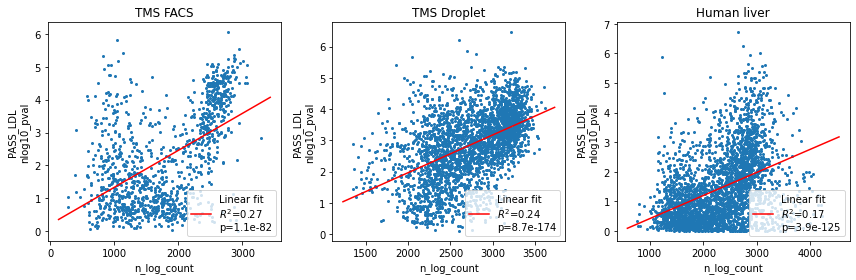

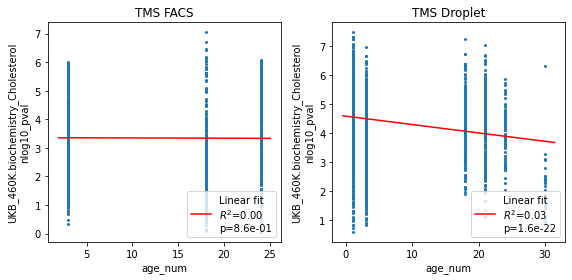

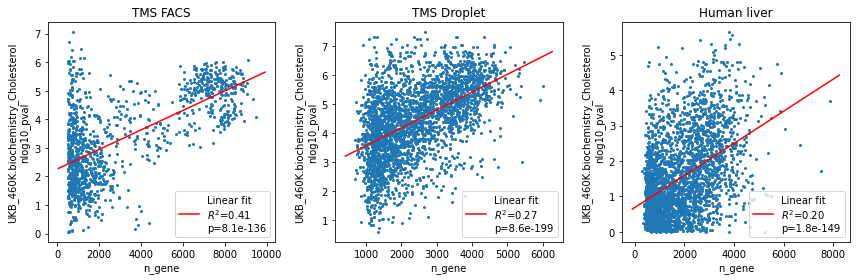

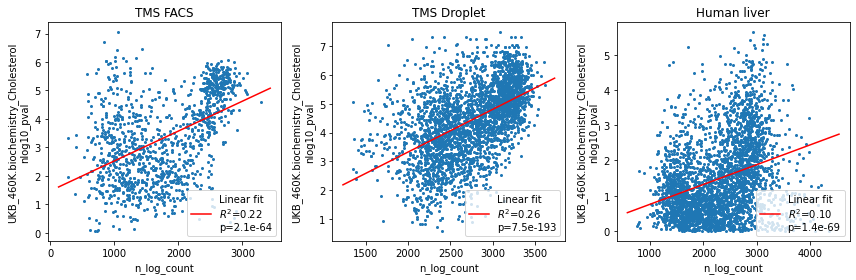

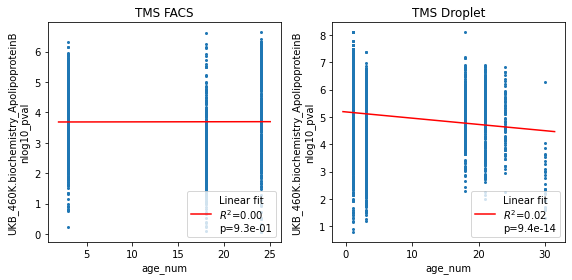

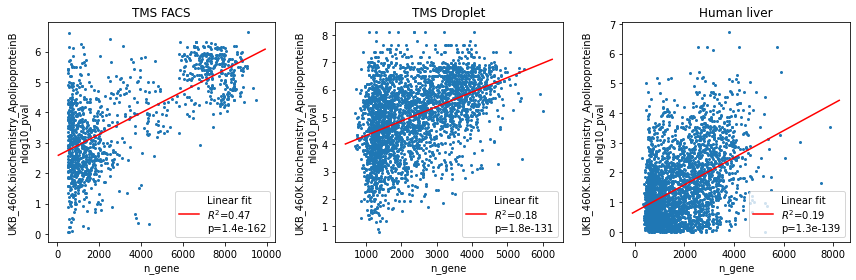

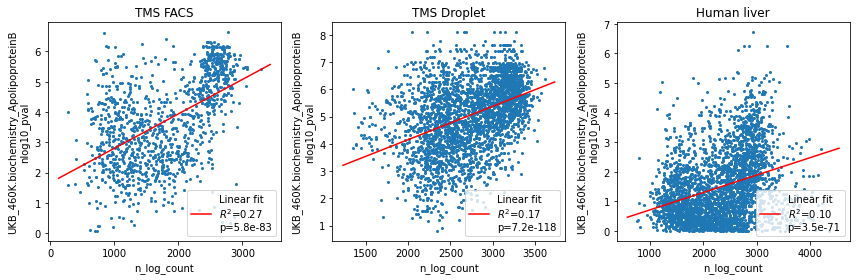

In [56]:
trait_list_plot = list(set(dic_trait_assoc_list['facs']) & 
                       set(dic_trait_assoc_list['droplet']) & 
                       set(dic_trait_assoc_list['aizarani']))
cov_list = ['age_num', 'n_gene', 'n_log_count']

for trait in trait_list_plot:
    for cov in cov_list:
        plt.figure(figsize=[12,4])
        for i_ds,ds in enumerate(['facs', 'droplet', 'aizarani']):
            
            if cov not in dic_data_raw[ds].obs.columns:
                continue

            v_x = dic_data_raw[ds].obs.loc[dic_cell_list[ds], cov].values
            v_y = -np.log10(dic_score[ds].loc[dic_cell_list[ds], '%s.pval'%trait])

            plt.subplot(1,3,i_ds+1)
            plt.scatter(v_x, v_y, s=4)

            # linear fit
            sl, icpt, r_val, p_val, _ = sp.stats.linregress(v_x[v_x>0], v_y[v_x>0])
            x_min,x_max = plt.xlim()
            y_min,y_max = plt.ylim()
            plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
                     label='Linear fit\n$R^2$=%0.2f\np=%0.1e'%(r_val**2, p_val))
            plt.legend(loc='lower right')

            plt.xlabel(cov)
            plt.ylabel('%s\nnlog10_pval'%trait)
            plt.title(DIC_INFO[ds]['dname'])

        plt.tight_layout()
        plt.show()
#         break
#     break

### Various markers 

In [13]:
dic_marker_gene = {}
dic_marker_gene['apoptosis.Fas'] = {'hsapiens': 'FAS', 'mmusculus':'Fas', 'info':'apoptosis'}
dic_marker_gene['apoptosis.Tnfsf10'] = {'hsapiens': 'TNFSF10', 'mmusculus':'Tnfsf10', 'info':'apoptosis'}
dic_marker_gene['apoptosis.Hmgb1'] = {'hsapiens': 'HMGB1', 'mmusculus':'Hmgb1', 'info':'apoptosis'}
dic_marker_gene['pericentral.Glul'] = {'hsapiens': 'GLUL', 'mmusculus':'Glul', 'info':'pericentral'}
dic_marker_gene['pericentral.Cyp2e1'] = {'hsapiens': 'CYP2E1', 'mmusculus':'Cyp2e1', 'info':'pericentral'}
dic_marker_gene['periportal.Ass1'] = {'hsapiens': 'ASS1', 'mmusculus':'Ass1', 'info':'periportal'}
dic_marker_gene['periportal.Asl'] = {'hsapiens': 'ASL', 'mmusculus':'Asl', 'info':'periportal'}
dic_marker_gene['periportal.Alb'] = {'hsapiens': 'ALB', 'mmusculus':'Alb', 'info':'periportal'}
dic_marker_gene['periportal.Cyp2f2'] = {'hsapiens': 'CYP2F1', 'mmusculus':'Cyp2f2', 'info':'periportal'}

# check if genes exist:
for gene in dic_marker_gene.keys():
    if dic_marker_gene[gene]['mmusculus'] not in dic_data_raw['facs'].var_names:
        print(dic_marker_gene[gene]['mmusculus'])
    
    if dic_marker_gene[gene]['mmusculus'] not in dic_data_raw['droplet'].var_names:
        print(dic_marker_gene[gene]['mmusculus'])
        
    if dic_marker_gene[gene]['hsapiens'] not in dic_data_raw['aizarani'].var_names:
        print(dic_marker_gene[gene]['hsapiens'])

CYP2F1


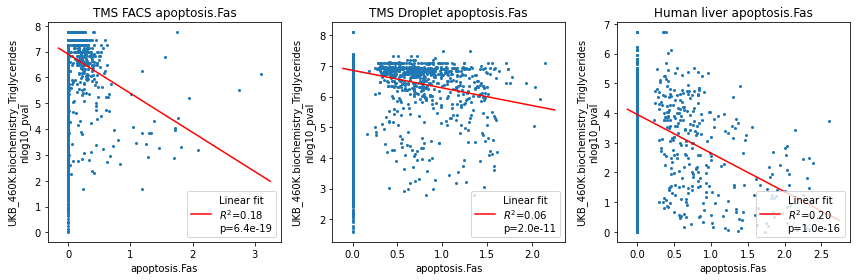

In [20]:
trait = 'UKB_460K.biochemistry_Triglycerides'
for gene in dic_marker_gene.keys():
    plt.figure(figsize=[12,4])
    for i_ds,ds in enumerate(['facs', 'droplet', 'aizarani']):
        
        if dic_marker_gene[gene][DIC_INFO[ds]['species']] not in dic_data_raw[ds].var_names:
            continue
            
        v_x = dic_data_raw[ds][dic_cell_list[ds], 
                               dic_marker_gene[gene][DIC_INFO[ds]['species']]].X.toarray().reshape([-1])
        v_y = -np.log10(dic_score[ds].loc[dic_cell_list[ds], '%s.pval'%trait])
        
        plt.subplot(1,3,i_ds+1)
        plt.scatter(v_x, v_y, s=4)
        
        # linear fit
        sl, icpt, r_val, p_val, _ = sp.stats.linregress(v_x[v_x>0], v_y[v_x>0])
        x_min,x_max = plt.xlim()
        y_min,y_max = plt.ylim()
        plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
                 label='Linear fit\n$R^2$=%0.2f\np=%0.1e'%(r_val**2, p_val))
        plt.legend(loc='lower right')

        plt.xlabel(gene)
        plt.ylabel('%s\nnlog10_pval'%trait)
        plt.title('%s %s'%(DIC_INFO[ds]['dname'], gene))

    plt.tight_layout()
    plt.show()
    break

In [15]:

# for gene in dic_marker_gene.keys():
#     plt.figure(figsize=[15,5])
#     for i_ds,ds in enumerate(['facs', 'droplet', 'aizarani']):
        
#         if dic_marker_gene[gene][DIC_SPECIES[ds]] not in dic_data_raw[ds].var_names:
#             continue
            
#         df_plot = pd.DataFrame(index=dic_data_processed[ds].obs_names,
#                                data={'UMAP1':dic_data_processed[ds].obsm['X_umap'][:,0],
#                                      'UMAP2':dic_data_processed[ds].obsm['X_umap'][:,1]})
#         temp_df = pd.DataFrame(index=dic_data_raw[ds].obs_names,
#                                data={gene:dic_data_raw[ds][:, dic_marker_gene[gene][DIC_SPECIES[ds]]].X.toarray().reshape([-1])})
#         df_plot = df_plot.join(temp_df)
#         df_plot = df_plot.loc[dic_cell_list[ds]]
        
#         plt.subplot(1,3,i_ds+1)
#         plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[gene], cmap='Reds', vmin=0, s=4)
#         plt.colorbar()
#         plt.xlabel('UMAP1')
#         plt.ylabel('UMAP2')
#         plt.title('%s %s (%s)'%(DIC_DNAME[ds], gene, dic_marker_gene[gene]['info']))

#     plt.tight_layout()
#     plt.show()
    

NameError: name 'DIC_SPECIES' is not defined

<Figure size 1080x360 with 0 Axes>

### Pathway

... storing 'tissue_celltype' as categorical


facs
         Falling back to preprocessing with `sc.pp.pca` and default params.


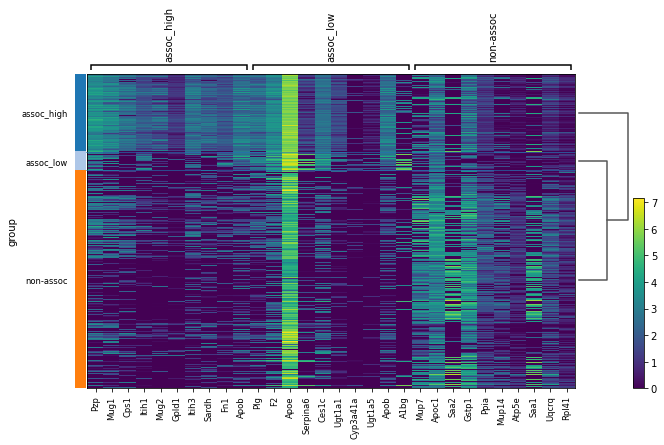

In [61]:
# Stratify by n_gene
from gprofiler import GProfiler

def assign_group(x,y):
    if x&(y<2000):
        return 'assoc_low'
    elif x&(y>=2000):
        return 'assoc_high'
    else:
        return 'non-assoc'

dic_pathway = {}
trait = 'PASS_LDL'
for i_ds,ds in enumerate(['facs']):
    
    print(ds)
    # Select marker genes 
    adata_small=dic_data_raw[ds][dic_cell_list[ds], :].copy()
    adata_small.obs['group'] = (dic_score[ds].loc[dic_cell_list[ds], '%s.fdr'%trait]<0.2)
    adata_small.obs['group'] = [assign_group(x,y)
                                for x,y in zip(adata_small.obs['group'], adata_small.obs['n_gene'])]
    adata_small.obs['group'] = adata_small.obs['group'].astype('category')
    sc.tl.rank_genes_groups(adata_small, groupby='group', method='t-test_overestim_var')
    sc.pl.rank_genes_groups_heatmap(adata_small)
    
    gp = GProfiler(return_dataframe=True)
    df_pathway = gp.profile(organism=DIC_INFO[ds]['species'], 
                            query=list(adata_small.uns['rank_genes_groups']['names']['assoc_low']),
                            sources=['KEGG', 'GO:BP', 'REAC'],
                            significance_threshold_method='fdr', 
                            user_threshold=0.01,
                            background=list(dic_data_raw[ds].var_names))
    ind_select = (df_pathway['term_size']<500) & (df_pathway['term_size']>5) & (df_pathway['intersection_size']>10)
    dic_pathway['%s.%s.assoc_low'%(ds, trait)] = df_pathway.loc[ind_select].copy()
    
    gp = GProfiler(return_dataframe=True)
    df_pathway = gp.profile(organism=DIC_INFO[ds]['species'], 
                            query=list(adata_small.uns['rank_genes_groups']['names']['assoc_high']),
                            sources=['KEGG', 'GO:BP', 'REAC'],
                            significance_threshold_method='fdr', 
                            user_threshold=0.01,
                            background=list(dic_data_raw[ds].var_names))
    ind_select = (df_pathway['term_size']<500) & (df_pathway['term_size']>5) & (df_pathway['intersection_size']>10)
    dic_pathway['%s.%s.assoc_high'%(ds, trait)] = df_pathway.loc[ind_select].copy()
    
    gp = GProfiler(return_dataframe=True)
    df_pathway = gp.profile(organism=DIC_INFO[ds]['species'], 
                            query=list(adata_small.uns['rank_genes_groups']['names']['non-assoc']),
                            sources=['KEGG', 'GO:BP', 'REAC'],
                            significance_threshold_method='fdr', 
                            user_threshold=0.01,
                            background=list(dic_data_raw[ds].var_names))
    ind_select = (df_pathway['term_size']<500) & (df_pathway['term_size']>5) & (df_pathway['intersection_size']>10)
    dic_pathway['%s.%s.non-assoc'%(ds, trait)] = df_pathway.loc[ind_select].copy()
    

for term in dic_pathway.keys():
    dic_pathway[term].index = ['%s.%s'%(x,y) for x,y in zip(dic_pathway[term]['source'], dic_pathway[term]['name'])]

In [65]:
dic_pathway['%s.%s.non-assoc'%(ds, trait)]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
KEGG.Oxidative phosphorylation,KEGG,KEGG:00190,Oxidative phosphorylation,3.949094e-29,True,Oxidative phosphorylation,114,78,21,21956,0.269231,0.184211,query_1,[KEGG:00000]
KEGG.Thermogenesis,KEGG,KEGG:04714,Thermogenesis,4.118897e-24,True,Thermogenesis,198,78,21,21956,0.269231,0.106061,query_1,[KEGG:00000]
KEGG.Parkinson disease,KEGG,KEGG:05012,Parkinson disease,1.509332e-21,True,Parkinson disease,224,78,20,21956,0.256410,0.089286,query_1,[KEGG:00000]
KEGG.Huntington disease,KEGG,KEGG:05016,Huntington disease,2.489202e-20,True,Huntington disease,261,78,20,21956,0.256410,0.076628,query_1,[KEGG:00000]
KEGG.Prion disease,KEGG,KEGG:05020,Prion disease,1.958260e-19,True,Prion disease,246,78,19,21956,0.243590,0.077236,query_1,[KEGG:00000]
KEGG.Non-alcoholic fatty liver disease,KEGG,KEGG:04932,Non-alcoholic fatty liver disease,2.132677e-17,True,Non-alcoholic fatty liver disease,142,78,15,21956,0.192308,0.105634,query_1,[KEGG:00000]
KEGG.Amyotrophic lateral sclerosis,KEGG,KEGG:05014,Amyotrophic lateral sclerosis,2.272674e-17,True,Amyotrophic lateral sclerosis,322,78,19,21956,0.243590,0.059006,query_1,[KEGG:00000]
"REAC.Respiratory electron transport, ATP synthesis by chemiosmotic coupling, and heat production by uncoupling proteins.",REAC,REAC:R-MMU-163200,"Respiratory electron transport, ATP synthesis ...",3.967351e-17,True,"Respiratory electron transport, ATP synthesis ...",66,78,13,21956,0.166667,0.196970,query_1,[REAC:R-MMU-1428517]
KEGG.Alzheimer disease,KEGG,KEGG:05010,Alzheimer disease,1.168522e-15,True,Alzheimer disease,340,78,18,21956,0.230769,0.052941,query_1,[KEGG:00000]
KEGG.Ribosome,KEGG,KEGG:03010,Ribosome,7.862773e-15,True,Ribosome,132,78,13,21956,0.166667,0.098485,query_1,[KEGG:00000]


In [63]:
dic_pathway['%s.%s.assoc_low'%(ds, trait)]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
KEGG.Complement and coagulation cascades,KEGG,KEGG:04610,Complement and coagulation cascades,3.209829e-27,True,Complement and coagulation cascades,88,97,20,21956,0.206186,0.227273,query_1,[KEGG:00000]
REAC.Hemostasis,REAC,REAC:R-MMU-109582,Hemostasis,7.982164e-19,True,Hemostasis,487,97,26,21956,0.268041,0.053388,query_1,[REAC:0000000]
REAC.Platelet degranulation,REAC,REAC:R-MMU-114608,Platelet degranulation,1.719533e-18,True,Platelet degranulation,107,97,16,21956,0.164948,0.149533,query_1,[REAC:R-MMU-76005]
REAC.Response to elevated platelet cytosolic Ca2+,REAC,REAC:R-MMU-76005,Response to elevated platelet cytosolic Ca2+,1.719533e-18,True,Response to elevated platelet cytosolic Ca2+,109,97,16,21956,0.164948,0.146789,query_1,[REAC:R-MMU-76002]
REAC.Regulation of Insulin-like Growth Factor (IGF) transport and uptake by Insulin-like Growth Factor Binding Proteins (IGFBPs),REAC,REAC:R-MMU-381426,Regulation of Insulin-like Growth Factor (IGF)...,1.719533e-18,True,Regulation of Insulin-like Growth Factor (IGF)...,110,97,16,21956,0.164948,0.145455,query_1,[REAC:R-MMU-392499]
REAC.Post-translational protein phosphorylation,REAC,REAC:R-MMU-8957275,Post-translational protein phosphorylation,2.553221e-17,True,Post-translational protein phosphorylation,104,97,15,21956,0.154639,0.144231,query_1,[REAC:R-MMU-597592]
"REAC.Platelet activation, signaling and aggregation",REAC,REAC:R-MMU-76002,"Platelet activation, signaling and aggregation",4.432214e-16,True,"Platelet activation, signaling and aggregation",232,97,18,21956,0.185567,0.077586,query_1,[REAC:R-MMU-109582]
GO:BP.coagulation,GO:BP,GO:0050817,coagulation,6.095614e-16,True,"""The process in which a fluid solution, or par...",163,97,17,21956,0.175258,0.104294,query_1,[GO:0032501]
GO:BP.blood coagulation,GO:BP,GO:0007596,blood coagulation,6.095614e-16,True,"""The sequential process in which the multiple ...",160,97,17,21956,0.175258,0.106250,query_1,"[GO:0007599, GO:0042060, GO:0050817]"
GO:BP.hemostasis,GO:BP,GO:0007599,hemostasis,6.095614e-16,True,"""The stopping of bleeding (loss of body fluid)...",162,97,17,21956,0.175258,0.104938,query_1,[GO:0050878]


In [62]:
dic_pathway['%s.%s.assoc_high'%(ds, trait)]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
GO:BP.fatty acid metabolic process,GO:BP,GO:0006631,fatty acid metabolic process,1.237856e-13,True,"""The chemical reactions and pathways involving...",397,94,20,21956,0.212766,0.050378,query_1,"[GO:0032787, GO:0044255]"
KEGG.Complement and coagulation cascades,KEGG,KEGG:04610,Complement and coagulation cascades,4.734370e-13,True,Complement and coagulation cascades,88,94,12,21956,0.127660,0.136364,query_1,[KEGG:00000]
GO:BP.acylglycerol metabolic process,GO:BP,GO:0006639,acylglycerol metabolic process,4.977043e-12,True,"""The chemical reactions and pathways involving...",134,94,13,21956,0.138298,0.097015,query_1,"[GO:0006638, GO:0046486]"
GO:BP.triglyceride metabolic process,GO:BP,GO:0006641,triglyceride metabolic process,5.254012e-12,True,"""The chemical reactions and pathways involving...",104,94,12,21956,0.127660,0.115385,query_1,[GO:0006639]
GO:BP.neutral lipid metabolic process,GO:BP,GO:0006638,neutral lipid metabolic process,5.254012e-12,True,"""The chemical reactions and pathways involving...",136,94,13,21956,0.138298,0.095588,query_1,[GO:0044255]
GO:BP.blood coagulation,GO:BP,GO:0007596,blood coagulation,3.492687e-11,True,"""The sequential process in which the multiple ...",160,94,13,21956,0.138298,0.081250,query_1,"[GO:0007599, GO:0042060, GO:0050817]"
GO:BP.hemostasis,GO:BP,GO:0007599,hemostasis,3.809560e-11,True,"""The stopping of bleeding (loss of body fluid)...",162,94,13,21956,0.138298,0.080247,query_1,[GO:0050878]
GO:BP.coagulation,GO:BP,GO:0050817,coagulation,3.850449e-11,True,"""The process in which a fluid solution, or par...",163,94,13,21956,0.138298,0.079755,query_1,[GO:0032501]
GO:BP.organic anion transport,GO:BP,GO:0015711,organic anion transport,2.570871e-09,True,"""The directed movement of organic anions into,...",482,94,17,21956,0.180851,0.035270,query_1,"[GO:0006820, GO:0071702]"
GO:BP.glycerolipid metabolic process,GO:BP,GO:0046486,glycerolipid metabolic process,4.215390e-09,True,"""The chemical reactions and pathways involving...",363,94,15,21956,0.159574,0.041322,query_1,[GO:0044255]


In [74]:
from gprofiler import GProfiler

dic_pathway = {}
trait = 'UKB_460K.biochemistry_Cholesterol'
for i_ds,ds in enumerate(['facs', 'droplet', 'aizarani']):
    
    print(ds)
    adata_small=dic_data_raw[ds][dic_cell_list[ds], :].copy()
    adata_small.obs['group'] = (dic_score[ds].loc[dic_cell_list[ds], '%s.fdr'%trait]<0.1)
#     adata_small.obs['group'] = ['assoc' if x else 'non-assoc' for x in adata_small.obs['group']]
    adata_small.obs['group'] = ['assoc' if x&(y<2000) else 'non-assoc' 
                                for x,y in zip(adata_small.obs['group'], adata_small.obs['n_gene'])]
    adata_small.obs['group'] = adata_small.obs['group'].astype('category')
    sc.tl.rank_genes_groups(adata_small, groupby='group', method='t-test_overestim_var')
#     sc.pl.rank_genes_groups_heatmap(adata_small)
    
    gp = GProfiler(return_dataframe=True)
    df_pathway = gp.profile(organism=DIC_INFO[ds]['species'], 
                            query=list(adata_small.uns['rank_genes_groups']['names']['assoc']),
                            sources=['KEGG', 'GO:BP', 'REAC'],
                            significance_threshold_method='fdr', 
                            user_threshold=0.01,
                            background=list(dic_data_raw[ds].var_names))
    ind_select = (df_pathway['term_size']<500) & (df_pathway['term_size']>5) & (df_pathway['intersection_size']>10)
    dic_pathway['%s.%s.assoc'%(ds, trait)] = df_pathway.loc[ind_select].copy()
    
    gp = GProfiler(return_dataframe=True)
    df_pathway = gp.profile(organism=DIC_INFO[ds]['species'], 
                            query=list(adata_small.uns['rank_genes_groups']['names']['non-assoc']),
                            sources=['KEGG', 'GO:BP', 'REAC'],
                            significance_threshold_method='fdr', 
                            user_threshold=0.01,
                            background=list(dic_data_raw[ds].var_names))
    ind_select = (df_pathway['term_size']<500) & (df_pathway['term_size']>5) & (df_pathway['intersection_size']>10)
    dic_pathway['%s.%s.non-assoc'%(ds, trait)] = df_pathway.loc[ind_select].copy()
    

for term in dic_pathway.keys():
    dic_pathway[term].index = ['%s.%s'%(x,y) for x,y in zip(dic_pathway[term]['source'], dic_pathway[term]['name'])]

... storing 'tissue_celltype' as categorical


facs


... storing 'tissue_celltype' as categorical


droplet
aizarani


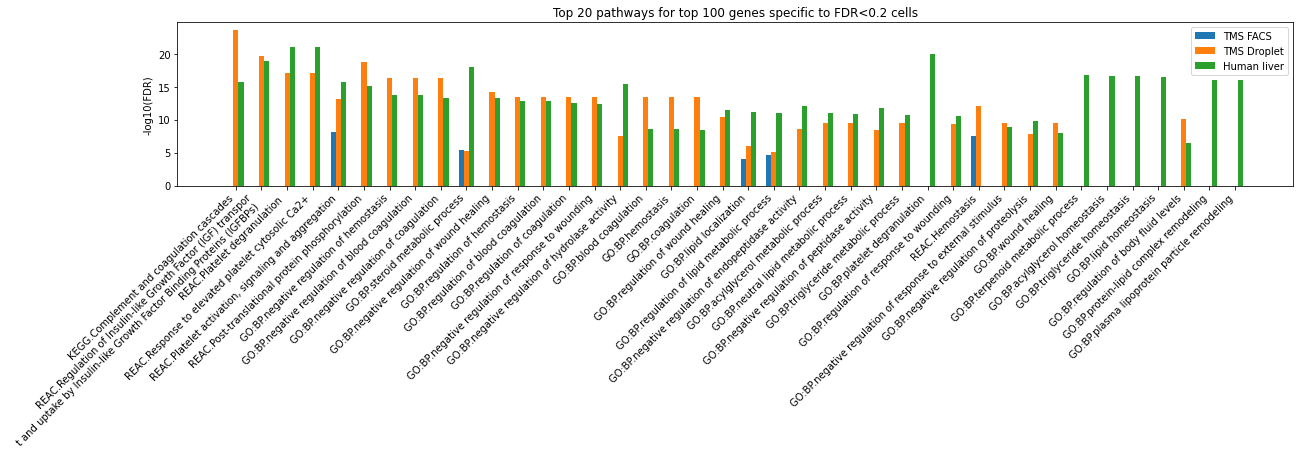

In [75]:
# Cross comparision: assoc-pathways 
temp_list = []
for i_ds,ds in enumerate(['facs', 'droplet', 'aizarani']):
    temp_list.extend(dic_pathway['%s.%s.assoc'%(ds, trait)].index)
df_plot = pd.DataFrame(index=sorted(set(temp_list)), columns=['facs', 'droplet', 'aizarani'], data=0)
for i_ds,ds in enumerate(['facs', 'droplet', 'aizarani']):
    term_list = list(set(df_plot.index) & set(dic_pathway['%s.%s.assoc'%(ds, trait)].index))
    df_plot.loc[term_list, ds] = -np.log10(dic_pathway['%s.%s.assoc'%(ds, trait)].loc[term_list,'p_value'].values)
df_plot['mean'] = df_plot.mean(axis=1)
# df_plot = df_plot.loc[df_plot['mean']>5]
df_plot = df_plot.sort_values(by=['mean'], ascending=False).iloc[:40,:]
df_plot['loc'] = range(df_plot.shape[0])
df_plot.index = [x[:60]+'\n'+x[60:] if len(x)>80 else x for x in df_plot.index]

plt.figure(figsize=[20,3])
plt.bar(df_plot['loc']-0.2, df_plot['facs'], width=0.2, label='TMS FACS')
plt.bar(df_plot['loc'], df_plot['droplet'], width=0.2, label='TMS Droplet')
plt.bar(df_plot['loc']+0.2, df_plot['aizarani'], width=0.2, label='Human liver')
plt.xticks(df_plot['loc'], df_plot.index, ha='right', rotation=45)
plt.ylabel('-log10(FDR)')
plt.legend()
plt.title('Top 20 pathways for top 100 genes specific to FDR<0.2 cells')
plt.show()

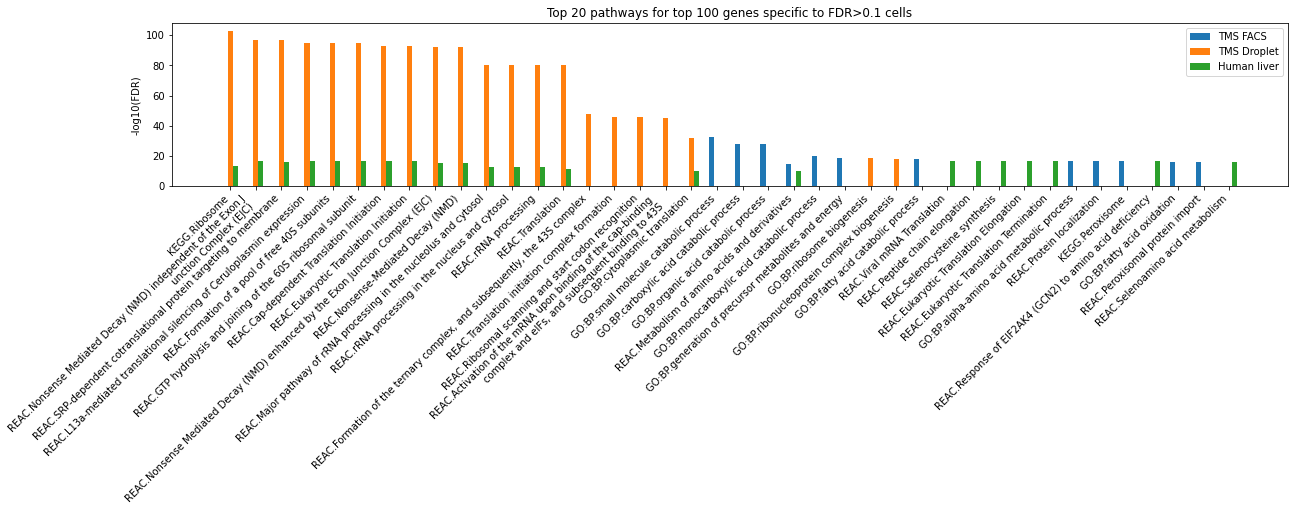

In [76]:
# Cross comparision: non-assoc-pathways 
temp_list = []
for i_ds,ds in enumerate(['facs', 'droplet', 'aizarani']):
    temp_list.extend(dic_pathway['%s.%s.non-assoc'%(ds, trait)].index)
df_plot = pd.DataFrame(index=sorted(set(temp_list)), columns=['facs', 'droplet', 'aizarani'], data=0)
for i_ds,ds in enumerate(['facs', 'droplet', 'aizarani']):
    term_list = list(set(df_plot.index) & set(dic_pathway['%s.%s.non-assoc'%(ds, trait)].index))
    df_plot.loc[term_list, ds] = -np.log10(dic_pathway['%s.%s.non-assoc'%(ds, trait)].loc[term_list,'p_value'].values)
df_plot['mean'] = df_plot.mean(axis=1)
# df_plot = df_plot.loc[df_plot['mean']>5]
df_plot = df_plot.sort_values(by=['mean'], ascending=False).iloc[:40,:]
df_plot['loc'] = range(df_plot.shape[0])
df_plot.index = [x[:60]+'\n'+x[60:] if len(x)>80 else x for x in df_plot.index]

plt.figure(figsize=[20,3])
plt.bar(df_plot['loc']-0.2, df_plot['facs'], width=0.2, label='TMS FACS')
plt.bar(df_plot['loc'], df_plot['droplet'], width=0.2, label='TMS Droplet')
plt.bar(df_plot['loc']+0.2, df_plot['aizarani'], width=0.2, label='Human liver')
plt.xticks(df_plot['loc'], df_plot.index, ha='right', rotation=45)
plt.ylabel('-log10(FDR)')
plt.legend()
plt.title('Top 20 pathways for top 100 genes specific to FDR>0.1 cells')
plt.show()
    